# Machine Learning to Estimate Number of Streams/Views for a song based on certain features

## Table of Contents:
1. Introduction
2. Preprocessing Visualizations
3. Data Processing
4. Visualization
5. Supervised Learning:

    a. Choosing Features

    b. Train/Test Split

    c. Linear Regression

    d. Checking for Outliers and Reducing Dimentions
    
    e. Random Forest, Hypertuning, Finding Best Parameters

    f. RandomSearchCV

    g. Gradient Boosing Regressor

    h. Tuning Data and Rerunning All Above Models

6. Checking for Overfitting
7. Rerunning Above Models w/ Diffderent Parameters:

    a. Reducing Dimentionality

    b. Identifying Most Important Features

    c. Correlation Matrix

    d. Rerunning Models

8. Unsupervised Learning:
    a. K-means CLustering for 2 Features

    b. PCA:

        i. Reducing Dimentionality to 5 and Rerunning Models

        ii. Reducing Dimentionality to 3 and Rerunning Models

9. Conclusion

    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.stats import linregress

The dataset I chose is a music dataset titled “Spotify and YouTube”. I found it on Kaggle, and it provides the satistics of the top 10 songs of different Spotify artists and their corresponding YouTube videos. The data was retrieved using the applications’ respective APIs. There is north of 17K different tracks (2K different artists) and 26 different variables (or features). Some of those features are generic such as song title and artist and album name, but the ones I want to focus mostly on are “danceability”, “speechiness”, “liveness”, “tempo”, etc. This data is presented in the form of an excel .csv file, which would allow me to easily import into python IDEs. Also, the data set is in the public domain (CC0: Public Domain). My main goal from this data set is to be able to train a model to recommend new music based on the features of liked songs.  

# Figure 1 - Shows the top 20 artists based off of Spotify Sream numbers:

### Load data from CSV

In [65]:
df = pd.read_csv('Spotify_Youtube.csv')

### Group by artist and sum the number of streams

In [66]:
artist_streams = df.groupby('Artist')['Stream'].sum().reset_index()

### Sort the data by the total number of streams in descending order

In [67]:
artist_streams = artist_streams.sort_values(by='Stream', ascending=False)

### Select the top 20 artists

In [68]:
top_20_artists = artist_streams.head(20)

### Plotting

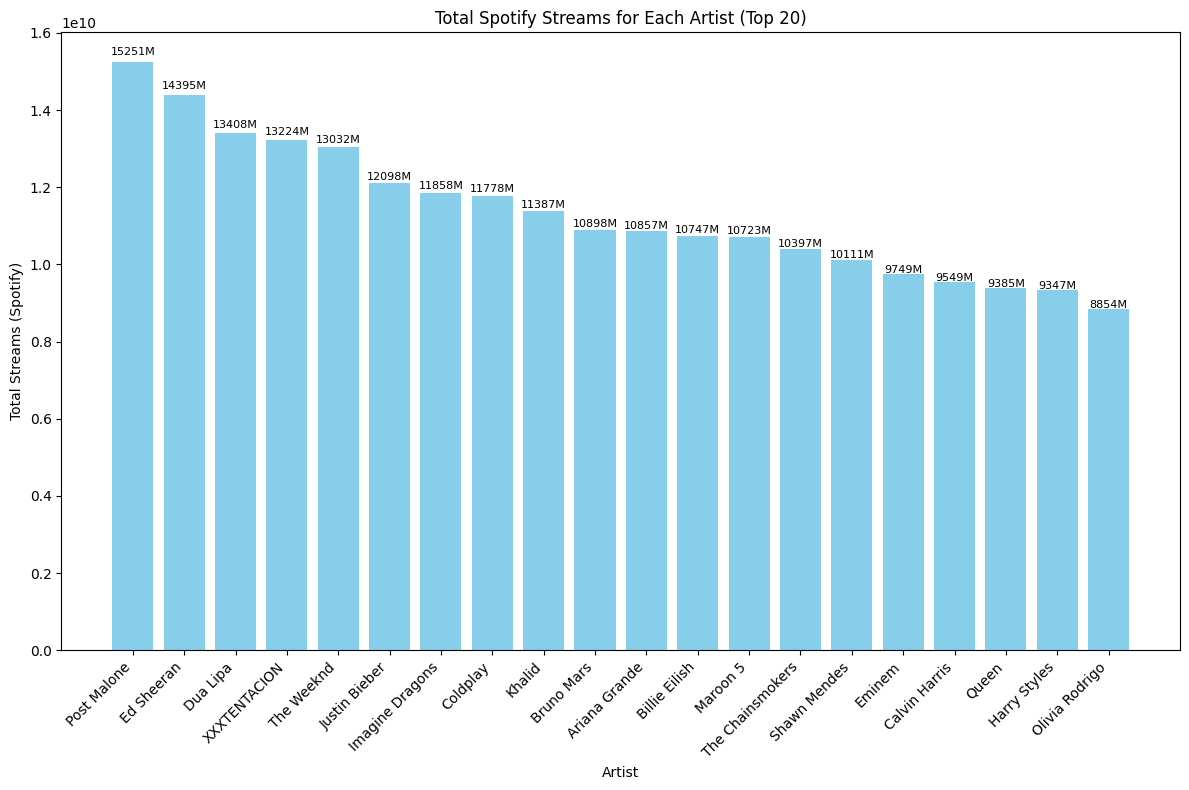

In [69]:
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_20_artists['Artist'])), top_20_artists['Stream'], color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Total Streams (Spotify)')
plt.title('Total Spotify Streams for Each Artist (Top 20)')
plt.xticks(range(len(top_20_artists['Artist'])), top_20_artists['Artist'], rotation=45, ha='right')

# Adding numbers on top of every bar 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval*1.025, f'{yval/1e6:.0f}M', ha='center',va='top', fontsize=8)

plt.tight_layout()
plt.savefig('top_20_artist_streams_plot.png')
plt.show()

# Figure 2 - Comparing Danceability and Speechiness in the top 1K songs
## Any song on spotify has a number vaue for a set of attributes. These are the attributes below:
- Danceability: describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- Energy: is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- Key: the key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- Speechiness: detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- Acousticness: a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- Instrumentalness: predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- Liveness: detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- Valence: a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
Tempo: the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

##### Select the top 1000 tracks based on stream count

In [70]:
top_1K_tracks = df.nlargest(1000, 'Stream')

# Plotting attributes against stream count

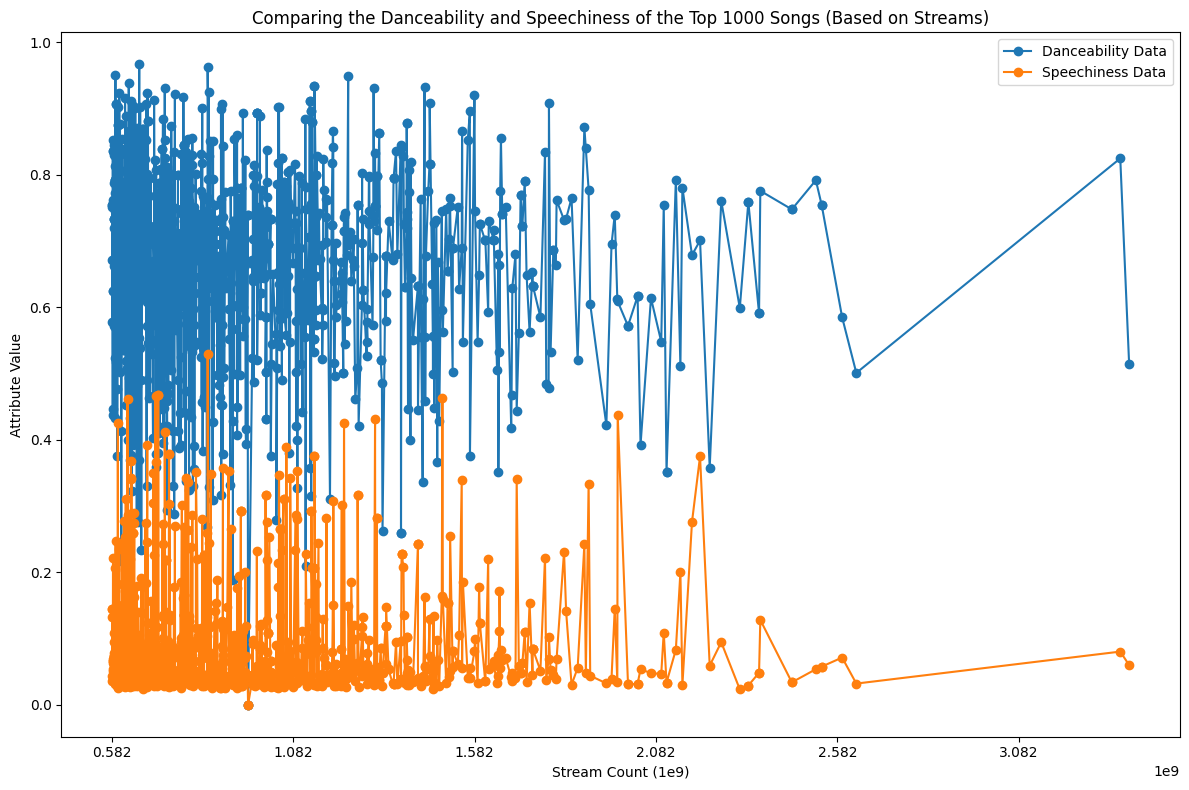

In [71]:
plt.figure(figsize=(12, 8))
attributes = ['Danceability','Speechiness']

for attribute in attributes:
    # Plot the data points
    plt.plot(top_1K_tracks['Stream'], top_1K_tracks[attribute],'o-', label=f'{attribute} Data')

plt.xlabel('Stream Count (1e9)')
plt.ylabel('Attribute Value')
plt.title('Comparing the Danceability and Speechiness of the Top 1000 Songs (Based on Streams)')
plt.legend()

# Set x-axis ticks to start from the minimum value of 'Stream'
min_stream = int(min(top_1K_tracks['Stream']))
max_stream = int(max(top_1K_tracks['Stream']))
subset_values = range(min_stream, max_stream, 500000000)  # Adjust the step size as needed
plt.xticks(subset_values)

plt.tight_layout()
plt.savefig('Danceability_vs_Speechiness_Top_1K_Songs.png')
plt.show()

#### Originally I had expected that more "speechy" music would be less common to stream more than once compared to more "danceable" songs. This graph clearly shows what I was expecting in the top streamed songs. 

## Interactive Chart

The interactive chart is the same as Figure 1. However, you are able to click on every barchart and it will give you the song-stream breakdown for the artist you clicked on their barchart. To access the interactive chart, run "interactive_chart.py" and open the https link that will be shown in ther cmd prompt.

# Ameliorating Data
## Recreating graph 1 but adding number of "Views" from YouTube to the "Stream" number from Spotify

In [72]:
# Create a new column 'Total' by adding the values in 'Stream' and 'Views'
df['Total'] = df['Stream'] + df['Views']

In [73]:
# Group by artist and sum the 'Total' values
artist_totals = df.groupby('Artist')['Total'].sum().reset_index()

# Sort the data by the total number of streams in descending order
artist_totals = artist_totals.sort_values(by='Total', ascending=False)

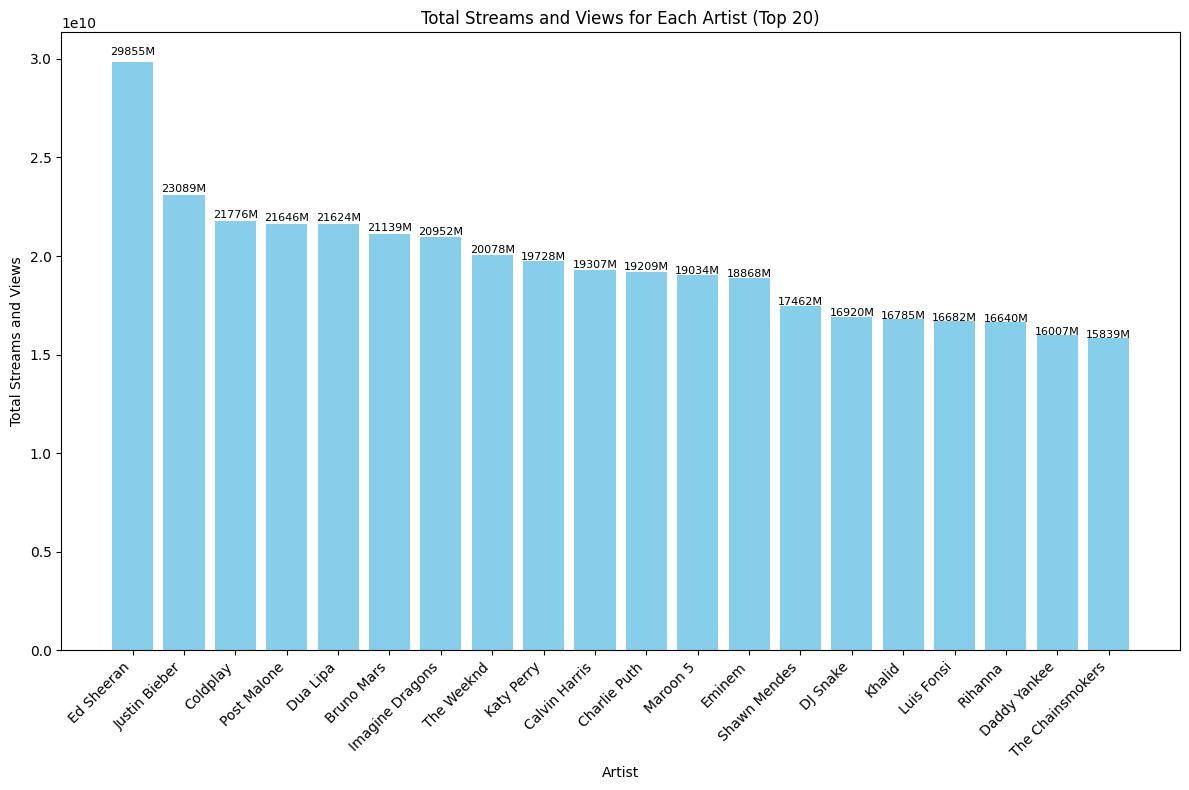

In [74]:
# Select the top 20 artists
top_20_artists = artist_totals.head(20)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_20_artists['Artist'])), top_20_artists['Total'], color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Total Streams and Views')
plt.title('Total Streams and Views for Each Artist (Top 20)')
plt.xticks(range(len(top_20_artists['Artist'])), top_20_artists['Artist'], rotation=45, ha='right')

# Individual bar labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval*1.025, f'{yval/1e6:.0f}M', ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()

#### Spotify was not created till 2006, and did not hit 1M subscribers till 2011. Some of the Artists with hits older than that such as Daddy Yankee with Gasolina (2004) gained popularity when Spotify was still in its infancy. For reference, YouTube was launched in 2005 and had by Jan 2006, the number of views had increased to more than 25 million/day.

## Cleaning data
### Eliminating all entries that have either no YouTube views or no Spotify streams.

In [75]:
# Get the number of rows
num_rows = df.shape[0]

print(f'The number of data points (rows) is: {num_rows}')

The number of data points (rows) is: 20718


In [76]:
# Load your data into a DataFrame
df = pd.read_csv('Spotify_Youtube.csv')

# Remove rows with 0 or NaN in either "Views" or "Stream" column
df = df[(df['Views'] != 0) & (df['Stream'] != 0) & (~df['Views'].isna()) & (~df['Stream'].isna())]


In [77]:
#Check for number of rows
num_rows_after_removal = len(df)
print(f'Number of rows after removing rows with 0 or NaN in Views or Stream: {num_rows_after_removal}')


Number of rows after removing rows with 0 or NaN in Views or Stream: 19692


In [78]:
# Save the updated DataFrame to a new CSV file or overwrite the existing file
df.to_csv('updated_data.csv', index=False)

#### Checking for any rows with duplicate "Artist" name and "Track Name"

In [79]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data.csv')

# Check for duplicate rows based on "Artist" and "Track"
duplicates = df[df.duplicated(['Artist', 'Track'], keep=False)]

# Display the duplicate rows
print('Duplicate Rows based on Artist and Track:')
print(duplicates)

# Display the number of duplicate rows
num_duplicates = len(duplicates)
print(f'Number of duplicate rows based on Artist and Track: {num_duplicates}')


Duplicate Rows based on Artist and Track:
       Unnamed: 0              Artist  \
725           772     Whitney Houston   
726           773     Whitney Houston   
1514         1621  Earth, Wind & Fire   
1518         1625  Earth, Wind & Fire   
1580         1687              Shaggy   
...           ...                 ...   
18069       19010            Soolking   
18128       19070               Beret   
18132       19074               Beret   
19592       20589          João Gomes   
19598       20595          João Gomes   

                                             Url_spotify            Track  \
725    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
726    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
1514   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1518   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1580   https://open.spotify.com/artist/5EvFsr3kj42KNv...     It Wasn't Me   
...

#### Only keeping the duplicate with highest Stream & Views number

In [80]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data.csv')

# Calculate the sum of "Stream" and "Views" for each group of "Artist" and "Track"
grouped_sum = df.groupby(['Artist', 'Track'])[['Stream', 'Views']].sum().reset_index()

# Identify the indices of the rows to keep (i.e., the ones with the maximum sum)
indices_to_keep = grouped_sum.groupby(['Artist', 'Track'])['Stream'].idxmax()

# Filter the original DataFrame using the identified indices
df_filtered = df.loc[indices_to_keep]

# Display the result
print('DataFrame after keeping rows with the highest sum of "Stream" and "Views":')
print(df_filtered)

# Save the updated DataFrame to a new CSV file or overwrite the existing file
df_filtered.to_csv('updated_data_filtered.csv', index=False)


DataFrame after keeping rows with the highest sum of "Stream" and "Views":
       Unnamed: 0            Artist  \
0               0          Gorillaz   
1               1          Gorillaz   
2               2          Gorillaz   
3               3          Gorillaz   
4               4          Gorillaz   
...           ...               ...   
19610       20607             Oruam   
19611       20608             Oruam   
19612       20615  Bailey Zimmerman   
19613       20616  Bailey Zimmerman   
19614       20617  Bailey Zimmerman   

                                             Url_spotify  \
0      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
1      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
2      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
3      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
4      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
...                                                  ...   
19610  https://open.spotify.com/arti

#### Checking that there are no more duplicates

In [81]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered.csv')

# Check for duplicate rows based on "Artist" and "Track"
duplicates = df[df.duplicated(['Artist', 'Track'], keep=False)]

# Display the duplicate rows
print('Duplicate Rows based on Artist and Track:')
print(duplicates)

# Display the number of duplicate rows
num_duplicates = len(duplicates)
print(f'Number of duplicate rows based on Artist and Track: {num_duplicates}')

Duplicate Rows based on Artist and Track:
       Unnamed: 0              Artist  \
725           772     Whitney Houston   
726           773     Whitney Houston   
1514         1621  Earth, Wind & Fire   
1518         1625  Earth, Wind & Fire   
1580         1687              Shaggy   
...           ...                 ...   
18069       19010            Soolking   
18128       19070               Beret   
18132       19074               Beret   
19592       20589          João Gomes   
19598       20595          João Gomes   

                                             Url_spotify            Track  \
725    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
726    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
1514   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1518   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1580   https://open.spotify.com/artist/5EvFsr3kj42KNv...     It Wasn't Me   
...

In [82]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered.csv')

# Check for duplicate rows based on "Artist" and "Track"
duplicates = df[df.duplicated(['Artist', 'Track'], keep=False)]

# Display the duplicate rows
print('Duplicate Rows based on Artist and Track:')
print(duplicates)

# Display the number of duplicate rows
num_duplicates = len(duplicates)
print(f'Number of duplicate rows based on Artist and Track: {num_duplicates}')


Duplicate Rows based on Artist and Track:
       Unnamed: 0              Artist  \
725           772     Whitney Houston   
726           773     Whitney Houston   
1514         1621  Earth, Wind & Fire   
1518         1625  Earth, Wind & Fire   
1580         1687              Shaggy   
...           ...                 ...   
18069       19010            Soolking   
18128       19070               Beret   
18132       19074               Beret   
19592       20589          João Gomes   
19598       20595          João Gomes   

                                             Url_spotify            Track  \
725    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
726    https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
1514   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1518   https://open.spotify.com/artist/4QQgXkCYTt3BlE...          Fantasy   
1580   https://open.spotify.com/artist/5EvFsr3kj42KNv...     It Wasn't Me   
...

In [83]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered.csv')

# Calculate the sum of "Stream" and "Views" for each group of "Artist" and "Track"
grouped_sum = df.groupby(['Artist', 'Track'])[['Stream', 'Views']].sum().reset_index()

# Identify the indices of the rows to keep (i.e., the ones with the maximum sum)
indices_to_keep = grouped_sum.groupby(['Artist', 'Track'])['Stream'].idxmax()

# Filter the original DataFrame using the identified indices
df_filtered = df.loc[indices_to_keep]

# Display the result
print('DataFrame after keeping rows with the highest sum of "Stream" and "Views":')
print(df_filtered)

# Save the updated DataFrame to a new CSV file or overwrite the existing file
df_filtered.to_csv('updated_data_filtered.csv', index=False)


DataFrame after keeping rows with the highest sum of "Stream" and "Views":
       Unnamed: 0          Artist  \
0               0        Gorillaz   
1               1        Gorillaz   
2               2        Gorillaz   
3               3        Gorillaz   
4               4        Gorillaz   
...           ...             ...   
19533       20523  PinkPantheress   
19534       20524  PinkPantheress   
19535       20525  PinkPantheress   
19536       20526  PinkPantheress   
19537       20527  PinkPantheress   

                                             Url_spotify  \
0      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
1      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
2      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
3      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
4      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
...                                                  ...   
19533  https://open.spotify.com/artist/78rUTD7y6Cy67W...   


In [84]:
# Specify an example "Artist" and "Track" to check
example_artist = 'Whitney Houston'
example_track = 'How Will I Know'

# Check the rows in the original DataFrame
original_rows = df[(df['Artist'] == example_artist) & (df['Track'] == example_track)]

# Check the rows in the filtered DataFrame
filtered_rows = df_filtered[(df_filtered['Artist'] == example_artist) & (df_filtered['Track'] == example_track)]

# Display the original and filtered rows for comparison
print("Original Rows:")
print(original_rows)

print("\nFiltered Rows:")
print(filtered_rows)


Original Rows:
     Unnamed: 0           Artist  \
725         772  Whitney Houston   
726         773  Whitney Houston   

                                           Url_spotify            Track  \
725  https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
726  https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   

                                                 Album Album_type  \
725  I Wanna Dance With Somebody (The Movie: Whitne...      album   
726                                    Whitney Houston      album   

                                      Uri  Danceability  Energy  Key  ...  \
725  spotify:track:22VVfcgjtL7XTemQcphB9N         0.758   0.683  6.0  ...   
726  spotify:track:5tdKaKLnC4SgtDZ6RlWeal         0.832   0.544  6.0  ...   

                                     Url_youtube  \
725  https://www.youtube.com/watch?v=m3-hY-hlhBg   
726  https://www.youtube.com/watch?v=m3-hY-hlhBg   

                                                 Titl

In [85]:
# Print the grouped sum for the specific example
print("Grouped Sum:")
print(grouped_sum[(grouped_sum['Artist'] == example_artist) & (grouped_sum['Track'] == example_track)])

# Print the indices to keep for the specific example
print("\nIndices to Keep:")
print(indices_to_keep[(example_artist, example_track)])


Grouped Sum:
                Artist            Track       Stream        Views
18685  Whitney Houston  How Will I Know  326653140.0  259193890.0

Indices to Keep:
18685


In [86]:
# Print the rows in the original DataFrame for the specific example
print("Rows in the Original DataFrame for the Specific Example:")
print(df.loc[indices_to_keep[(example_artist, example_track)]])


Rows in the Original DataFrame for the Specific Example:
Unnamed: 0                                                      19652
Artist                                                  Maria Becerra
Url_spotify         https://open.spotify.com/artist/1DxLCyH42yaHKG...
Track                                                           Marte
Album                                                   Mal De Amores
Album_type                                                      album
Uri                              spotify:track:1uK5rDY3BnikyG0sl3tPpc
Danceability                                                    0.704
Energy                                                          0.604
Key                                                               5.0
Loudness                                                       -5.254
Speechiness                                                    0.0556
Acousticness                                                    0.067
Instrumentalness                 

In [87]:
# Check for duplicates in the original DataFrame for the specific example
duplicates_original = df[df.duplicated(['Artist', 'Track'], keep=False)]
print("\nDuplicate Rows in the Original DataFrame for the Specific Example:")
print(duplicates_original[(duplicates_original['Artist'] == example_artist) & (duplicates_original['Track'] == example_track)])



Duplicate Rows in the Original DataFrame for the Specific Example:
     Unnamed: 0           Artist  \
725         772  Whitney Houston   
726         773  Whitney Houston   

                                           Url_spotify            Track  \
725  https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   
726  https://open.spotify.com/artist/6XpaIBNiVzIetE...  How Will I Know   

                                                 Album Album_type  \
725  I Wanna Dance With Somebody (The Movie: Whitne...      album   
726                                    Whitney Houston      album   

                                      Uri  Danceability  Energy  Key  ...  \
725  spotify:track:22VVfcgjtL7XTemQcphB9N         0.758   0.683  6.0  ...   
726  spotify:track:5tdKaKLnC4SgtDZ6RlWeal         0.832   0.544  6.0  ...   

                                     Url_youtube  \
725  https://www.youtube.com/watch?v=m3-hY-hlhBg   
726  https://www.youtube.com/watch?v=m3-hY-hlhBg   



In [88]:
import pandas as pd

# Load your data into a DataFrame
df = pd.read_csv('updated_data.csv')

# Add a column to identify duplicates
df['Duplicated'] = df.duplicated(['Artist', 'Track'], keep=False)

# Remove duplicate rows based on "Artist" and "Track" in the original DataFrame
df.drop_duplicates(['Artist', 'Track'], inplace=True)

# Reset the index of df
df.reset_index(drop=True, inplace=True)

# Recalculate the grouped sum and indices to keep
grouped_sum = df.groupby(['Artist', 'Track'])[['Stream', 'Views']].sum().reset_index()

# Sort the groups by the sum of "Stream" and "Views" in descending order
grouped_sum_sorted = grouped_sum.sort_values(['Stream', 'Views'], ascending=[False, False])

# Identify the indices of the rows to keep (i.e., the ones with the maximum sum)
indices_to_keep = grouped_sum_sorted.groupby(['Artist', 'Track'])['Stream'].idxmax()

# Add a column to indicate whether a row is kept or removed
df['Kept'] = df.index.isin(indices_to_keep)

# Filter the original DataFrame using the updated indices
df_filtered = df.loc[indices_to_keep]

# Display the result
print('DataFrame after keeping rows with the highest sum of "Stream" and "Views":')
print(df_filtered)

# Display the removed duplicates
removed_duplicates = df[df['Duplicated'] & ~df['Kept']]
print('Removed Duplicates:')
print(removed_duplicates)


DataFrame after keeping rows with the highest sum of "Stream" and "Views":
       Unnamed: 0       Artist  \
0               0     Gorillaz   
1               1     Gorillaz   
2               2     Gorillaz   
3               3     Gorillaz   
4               4     Gorillaz   
...           ...          ...   
19610       20713  SICK LEGEND   
19611       20714  SICK LEGEND   
19612       20715  SICK LEGEND   
19613       20716  SICK LEGEND   
19614       20717  SICK LEGEND   

                                             Url_spotify  \
0      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
1      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
2      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
3      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
4      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
...                                                  ...   
19610  https://open.spotify.com/artist/3EYY5FwDkHEYLw...   
19611  https://open.spotify.com/arti

In [89]:
# Identify the rows that were removed
removed_rows = df[~df['Kept']]

# Display the removed rows
print("Removed Rows:")
print(removed_rows)

# Display the original DataFrame for comparison
print("\nOriginal DataFrame:")
print(df)


Removed Rows:
Empty DataFrame
Columns: [Unnamed: 0, Artist, Url_spotify, Track, Album, Album_type, Uri, Danceability, Energy, Key, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo, Duration_ms, Url_youtube, Title, Channel, Views, Likes, Comments, Description, Licensed, official_video, Stream, Duplicated, Kept]
Index: []

[0 rows x 30 columns]

Original DataFrame:
       Unnamed: 0       Artist  \
0               0     Gorillaz   
1               1     Gorillaz   
2               2     Gorillaz   
3               3     Gorillaz   
4               4     Gorillaz   
...           ...          ...   
19610       20713  SICK LEGEND   
19611       20714  SICK LEGEND   
19612       20715  SICK LEGEND   
19613       20716  SICK LEGEND   
19614       20717  SICK LEGEND   

                                             Url_spotify  \
0      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
1      https://open.spotify.com/artist/3AA28KZvwAUcZu...   
2      https:/

In [90]:
import pandas as pd

# Load the updated_data.csv with duplicates
original_with_duplicates = pd.read_csv("updated_data.csv")

# Compare shapes
print("Original DataFrame Shape:", df.shape)
print("DataFrame with Duplicates Shape:", original_with_duplicates.shape)
print("Filtered DataFrame Shape:", df_filtered.shape)

# Compare specific columns
original_sum = df['Stream'].sum()
original_with_duplicates_sum = original_with_duplicates['Stream'].sum()
filtered_sum = df_filtered['Stream'].sum()

print("\nOriginal Sum of 'Stream' Column:", original_sum)
print("Sum of 'Stream' Column in DataFrame with Duplicates:", original_with_duplicates_sum)
print("Filtered Sum of 'Stream' Column:", filtered_sum)


Original DataFrame Shape: (19615, 30)
DataFrame with Duplicates Shape: (19692, 28)
Filtered DataFrame Shape: (19615, 30)

Original Sum of 'Stream' Column: 2692172362270.0
Sum of 'Stream' Column in DataFrame with Duplicates: 2696402888523.0
Filtered Sum of 'Stream' Column: 2692172362270.0


In [91]:
# Assuming your filtered DataFrame is named df_filtered
df_filtered.to_csv('updated_data_filtered_V2.csv', index=False)


In [92]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered_V2.csv')

# Check for duplicate rows based on "Artist" and "Track"
duplicates = df[df.duplicated(['Artist', 'Track'], keep=False)]

# Display the duplicate rows
print('Duplicate Rows based on Artist and Track:')
print(duplicates)

# Display the number of duplicate rows
num_duplicates = len(duplicates)
print(f'Number of duplicate rows based on Artist and Track: {num_duplicates}')

Duplicate Rows based on Artist and Track:
Empty DataFrame
Columns: [Unnamed: 0, Artist, Url_spotify, Track, Album, Album_type, Uri, Danceability, Energy, Key, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo, Duration_ms, Url_youtube, Title, Channel, Views, Likes, Comments, Description, Licensed, official_video, Stream, Duplicated, Kept]
Index: []

[0 rows x 30 columns]
Number of duplicate rows based on Artist and Track: 0


In [93]:
#Check for number of rows
num_rows_after_removal = len(df)
print(f'Number of rows after removing rows with 0 or NaN in Views or Stream or any duplicates: {num_rows_after_removal}')

Number of rows after removing rows with 0 or NaN in Views or Stream or any duplicates: 19615


### Replotting Graph after eliminating duplicates

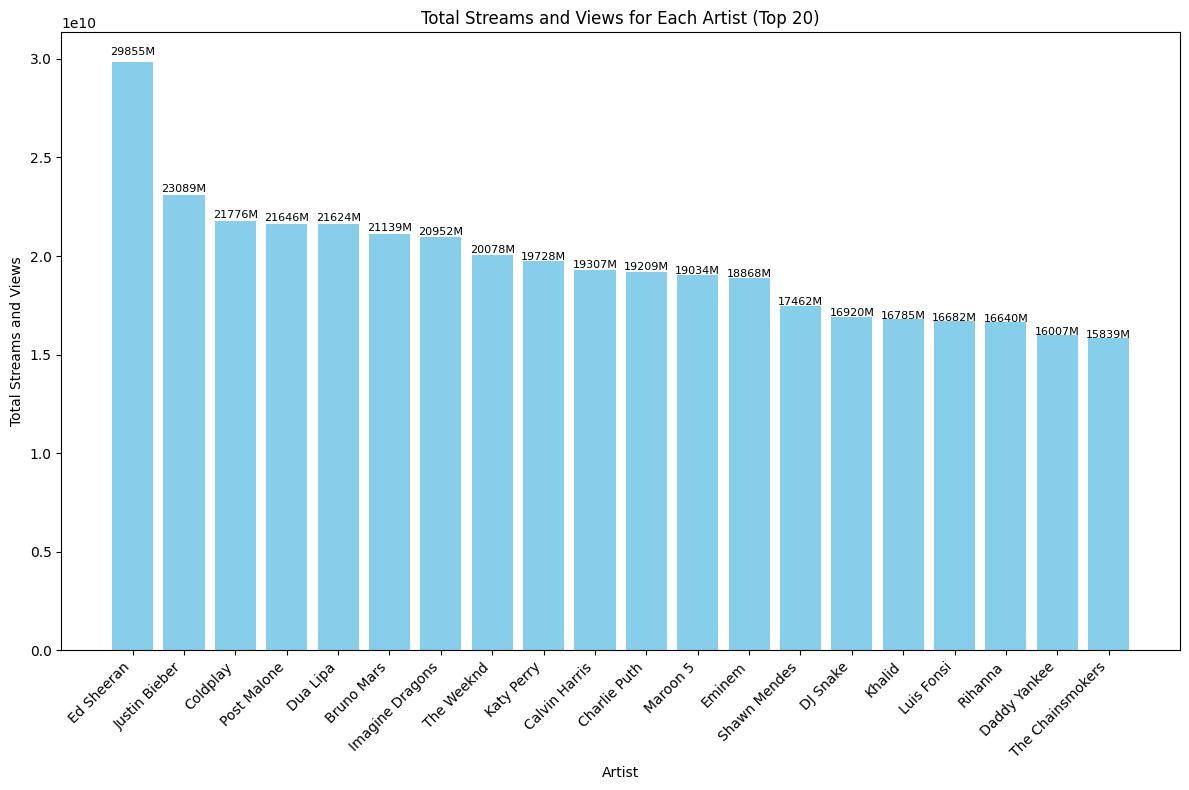

In [94]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered_V2.csv')

# Create a new column 'Total' by adding the values in 'Stream' and 'Views'
df['Total'] = df['Stream'] + df['Views']

# Group by artist and sum the 'Total' values
artist_totals = df.groupby('Artist')['Total'].sum().reset_index()

# Sort the data by the total number of streams in descending order
artist_totals = artist_totals.sort_values(by='Total', ascending=False)

# Select the top 20 artists
top_20_artists = artist_totals.head(20)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_20_artists['Artist'])), top_20_artists['Total'], color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Total Streams and Views')
plt.title('Total Streams and Views for Each Artist (Top 20)')
plt.xticks(range(len(top_20_artists['Artist'])), top_20_artists['Artist'], rotation=45, ha='right')

# Individual bar labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval*1.025, f'{yval/1e6:.0f}M', ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()

## Starting Supervised Learning

In [116]:
import sklearn as skl

##### Removing unnecessary columns

In [117]:
# List of columns to drop
columns_to_drop = ['Url_spotify', 'Album', 'Album_type', 'Uri', 'Url_youtube', 'Title', 'Channel', 'Likes', 'Comments', 'Description', 'Licensed', 'official_video']

# Drop the specified columns
df_filtered = df_filtered.drop(columns=columns_to_drop)

# Save the filtered DataFrame to a new CSV file, overwriting the existing file
df_filtered.to_csv('updated_data_filtered_V2.csv', index=False)


KeyError: "['Url_spotify', 'Album', 'Album_type', 'Uri', 'Url_youtube', 'Title', 'Channel', 'Likes', 'Comments', 'Description', 'Licensed', 'official_video'] not found in axis"

In [118]:
# Load your data into a DataFrame
df = pd.read_csv('updated_data_filtered_V2.csv')

In [114]:
# Create a new column 'Total_Streams_Views' as the sum of 'Stream' and 'Views'
df_filtered['Total_Streams_Views'] = df_filtered['Stream'] + df_filtered['Views']

# Drop the 'Stream' and 'Views' columns
df_filtered = df_filtered.drop(['Stream', 'Views'], axis=1)

# Save the DataFrame without 'Stream' and 'Views' to another CSV file
df_filtered.to_csv('updated_data_filtered_V2_with_total.csv', index=False)

KeyError: 'Stream'

In [107]:
# check for missing values
#print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Save the updated dataset
df.to_csv('updated_data_filtered_V2_with_total.csv', index=False)


In [109]:
# Drop rows with missing values
df_cleaned = df.dropna()

# Check for missing values again
missing_values_after_cleaning = df_cleaned.isnull().sum()

# Display missing values after cleaning
print("Missing Values After Cleaning:")
print(missing_values_after_cleaning)

Missing Values After Cleaning:
Unnamed: 0          0
Artist              0
Track               0
Danceability        0
Energy              0
Key                 0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
Views               0
Stream              0
Duplicated          0
Kept                0
dtype: int64


In [112]:
# Create a new feature 'Total_Streams_Views'
df_cleaned['Total_Streams_Views'] = df_cleaned['Stream'] + df_cleaned['Views']

# Drop 'Stream' and 'Views' columns
df_cleaned = df_cleaned.drop(['Stream', 'Views'], axis=1)

KeyError: 'Stream'

### Setting up train (80%) and test size (20%): 

In [119]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df_cleaned.drop('Total_Streams_Views', axis=1)
y = df_cleaned['Total_Streams_Views']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (15691, 16)
X_test shape: (3923, 16)
y_train shape: (15691,)
y_test shape: (3923,)


In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


ValueError: could not convert string to float: 'Carlos Vives'

In [122]:
# Drop non-numeric columns
X = X.drop(['Artist', 'Track'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.4733158474905462e+17


##### mean square error is tooo high - will try scaling and eliminating more features that don't help
##### will start by visualizing tempo and duration (since they are not scaled to 0-1)
##### Then check for outliers
##### Then eliminate: loudness (and maybe duration)
##### Last rerun the model

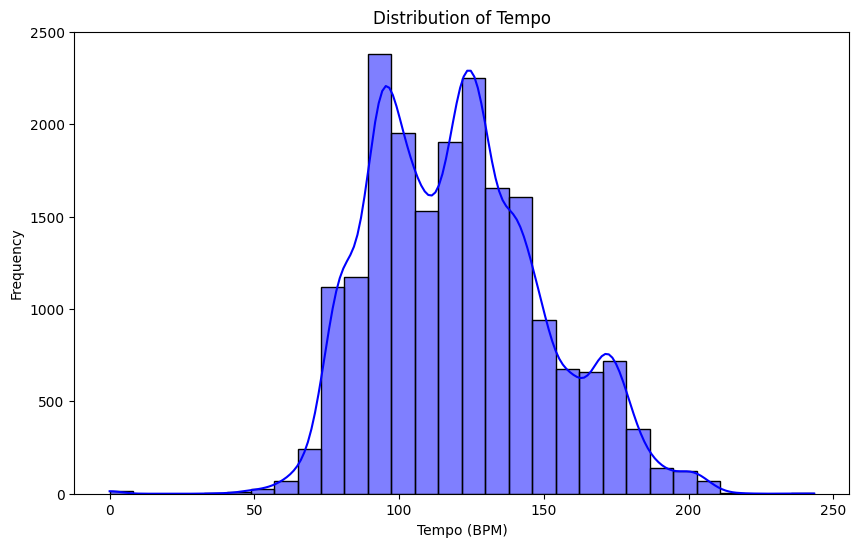

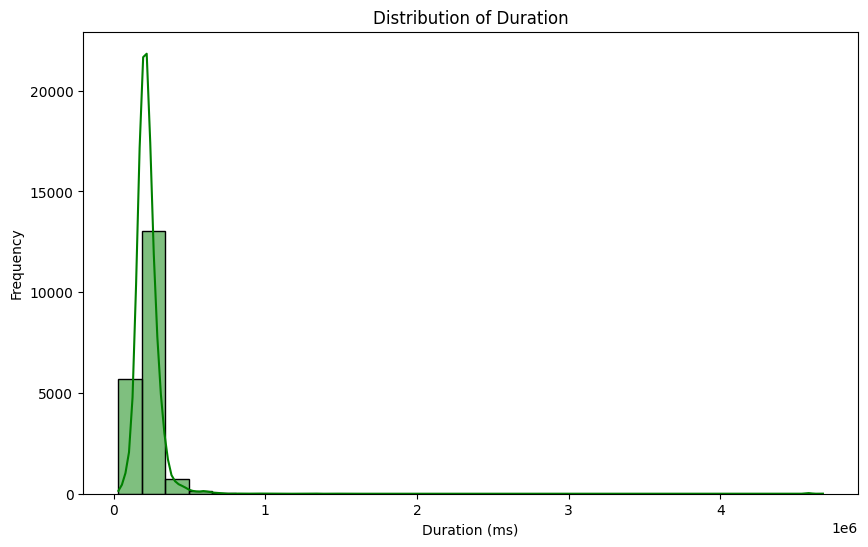

In [125]:
import seaborn as sns

# Visualize Tempo Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Tempo'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tempo')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.show()

# Visualize Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Duration_ms'], bins=30, kde=True, color='green')
plt.title('Distribution of Duration')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.show()

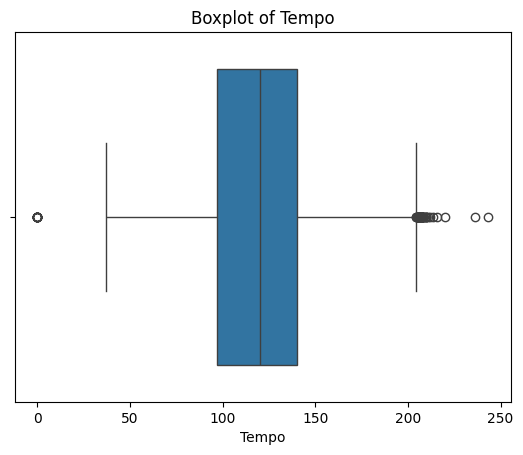

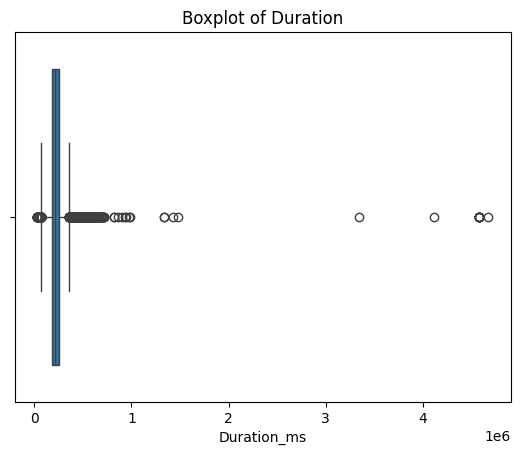

In [127]:
# Check for Outliers in Tempo
sns.boxplot(x=df['Tempo'])
plt.title('Boxplot of Tempo')
plt.show()

# Check for Outliers in Duration
sns.boxplot(x=df['Duration_ms'])
plt.title('Boxplot of Duration')
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler

# Remove Duration and Loudness
# df = df.drop(['Duration_ms', 'Loudness'], axis=1)

# Scale Tempo
scaler_tempo = StandardScaler()
df['Tempo'] = scaler_tempo.fit_transform(df[['Tempo']])


In [132]:
# retrying model
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = df.drop(['Views', 'Stream'], axis=1)  # Features
y = df['Views'] + df['Stream']  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (15692, 14) (15692,)
Testing set shape: (3923, 14) (3923,)


In [133]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


Unnamed: 0          0
Artist              0
Track               0
Danceability        1
Energy              1
Key                 1
Speechiness         1
Acousticness        1
Instrumentalness    1
Liveness            1
Valence             1
Tempo               1
Views               0
Stream              0
Duplicated          0
Kept                0
dtype: int64


In [134]:
df = df.dropna()

In [135]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Unnamed: 0          0
Artist              0
Track               0
Danceability        0
Energy              0
Key                 0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Views               0
Stream              0
Duplicated          0
Kept                0
dtype: int64


In [136]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


ValueError: could not convert string to float: 'Carlos Vives'

In [137]:
# Drop non-numeric columns from X
X_train = X_train.drop(['Artist', 'Track'], axis=1)
X_test = X_test.drop(['Artist', 'Track'], axis=1)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [138]:
# Drop rows with missing values from both X_train and y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Drop rows with missing values from X_test
X_test = X_test.dropna()


In [139]:
# Check the number of rows in the training set after dropping missing values
num_rows_train = len(X_train)
print(f"Number of rows in training set after handling missing values: {num_rows_train}")

# Check the number of rows in the testing set after dropping missing values
num_rows_test = len(X_test)
print(f"Number of rows in testing set after handling missing values: {num_rows_test}")


Number of rows in training set after handling missing values: 15691
Number of rows in testing set after handling missing values: 3923


In [140]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()
# Train the model on the training data
model.fit(X_train, y_train)


LinearRegression()

In [141]:
# Make predictions on the testing data
y_pred = model.predict(X_test)


In [142]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.277025747404781e+17


In [145]:
df = df.drop(["Key"], axis=1)
# Save the modified DataFrame to a new CSV file
df.to_csv('updated_data_filtered_V3.csv', index=False)

In [8]:
## Try 3
# Drop non-numerical columns
numerical_columns = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 
                     'Liveness', 'Valence', 'Tempo', 'Total_Views_Stream']

df_numerical = df[numerical_columns]

# Create the target variable
X = df_numerical.drop('Total_Views_Stream', axis=1)
y = df_numerical['Total_Views_Stream']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select a model (Linear Regression)
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


NameError: name 'train_test_split' is not defined

In [151]:
# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.486988581528674e+17


#### Trying a new regression model and hypertuning

In [4]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


NameError: name 'X_train' is not defined

In [153]:

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 2.169907749699271e+17


In [2]:
# Hypertuning:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    # Add other hyperparameters you want to tune
}

model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
# cv is the number of folds for cross-validation.
# scoring is the evaluation metric. Since we are dealing with regression, we use 'neg_mean_squared_error'.

In [3]:
grid_search.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [156]:
# get best paramteres
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}


In [157]:
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200)

In [158]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 2.1747832936613517e+17


#### Now trying randomized instead of grid search

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the parameter grid
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

# Create a random forest regressor model
rf_model = RandomForestRegressor(random_state=42)

# Set up the randomized search
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Get the best model
best_rf_model = random_search.best_estimator_

# Make predictions
y_pred_random = best_rf_model.predict(X_test) 

# Evaluate the model
mse_random = mean_squared_error(y_test, y_pred_random)
print("Best Parameters:", best_params)
print("Mean Squared Error (Randomized Search):", mse_random)


Best Parameters: {'max_depth': 18, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 143}
Mean Squared Error (Randomized Search): 2.0984854884867357e+17


In [16]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 5.658934488911547%


In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame and 'Total_Views_Stream' is your target variable

# Define features (X) and target variable (y)
X = df.drop(['Artist', 'Track', 'Total_Views_Stream'], axis=1)
y = df['Total_Views_Stream']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Define the parameter distributions for tuning
param_dist = {
    'model__n_estimators': randint(10, 200),
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20)
}

# Create the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.0897273519123686e+17


In [14]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 5.658934488911547%


### Trying Gradient Boosting Regressor

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with the relevant columns

# Define features and target variable
features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
target = 'Total_Views_Stream'

# Extract features and target variable
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(
    max_depth=18,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=3,
    n_estimators=143,
    random_state=42
)

# Train the model
gb_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test_scaled)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Mean Squared Error (Gradient Boosting Regressor): {mse_gb}")


Mean Squared Error (Gradient Boosting Regressor): 1.7001333361243142e+17


In [19]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred_gb - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 11.060142711518859%


#### Trying to bring back old Tempo and try to rerun some of these algs

In [26]:
old_df = pd.read_csv('updated_data_filtered_V2.csv')
df['Tempo'] = old_df['Tempo']
df.to_csv('updated_data_filtered_V3.csv', index=False)

In [28]:
import pandas as pd

df = pd.read_csv('updated_data_filtered_V3.csv')

features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
target = 'Total_Views_Stream'  # Adjust according to your target variable

from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [30]:
print(df['Tempo'].isnull().sum())


1


In [31]:
# Drop rows with missing values in the 'Tempo' column
df = df.dropna(subset=['Tempo'])

# Verify that the missing value has been removed
print(df['Tempo'].isnull().sum())


0


In [32]:
print(np.isinf(df['Tempo']).sum())

0


In [33]:
print(df['Tempo'].isnull().sum())

0


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [36]:
# Check for missing values in features
print(X_train.isnull().sum())

# Check for missing values in the target variable
print(y_train.isnull().sum())


Danceability        0
Energy              0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               1
dtype: int64
0


In [37]:
# Drop the row with missing value from both X and y
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


In [38]:
print(X_train.isnull().sum())


Danceability        0
Energy              0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


In [39]:
# Assuming df is your DataFrame
df.to_csv('updated_data_filtered_V3.csv', index=False)


In [40]:
old_df = pd.read_csv('updated_data_filtered_V2.csv')
df['Tempo'] = old_df['Tempo']
df.to_csv('updated_data_filtered_V3.csv', index=False)

In [41]:
import pandas as pd

df = pd.read_csv('updated_data_filtered_V3.csv')

features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
target = 'Total_Views_Stream'  # Adjust according to your target variable

from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.861369865391156e+17


In [43]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred_gb - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 7.033639143730887%


### Checking for overfitting

In [44]:
# Assuming you have already split your data into training and testing sets
# and trained your model (e.g., named `model`) on the training set

# Make predictions on both training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_within_tolerance = (abs(y_train_pred - y_train) / y_train) <= tolerance
train_percentage_within_tolerance = (sum(train_within_tolerance) / len(y_train)) * 100

# Evaluate performance on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_within_tolerance = (abs(y_test_pred - y_test) / y_test) <= tolerance
test_percentage_within_tolerance = (sum(test_within_tolerance) / len(y_test)) * 100

# Print the results
print("Training Set:")
print(f"MSE: {train_mse}")
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {train_percentage_within_tolerance}%")

print("\nTesting Set:")
print(f"MSE: {test_mse}")
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {test_percentage_within_tolerance}%")


Training Set:
MSE: 2.6135057523199564e+16
Percentage of predictions within 10% tolerance: 15.030309897456235%

Testing Set:
MSE: 1.861369865391156e+17
Percentage of predictions within 10% tolerance: 5.606523955147808%


In [45]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame and 'Total_Views_Stream' is your target variable

# Define features (X) and target variable (y)
X = df.drop(['Artist', 'Track', 'Total_Views_Stream'], axis=1)
y = df['Total_Views_Stream']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Define the parameter distributions for tuning
param_dist = {
    'model__n_estimators': randint(10, 200),
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20)
}

# Create the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.104408264401983e+17


In [47]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 6.449146061687484%


In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with the relevant columns

# Define features and target variable
features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
target = 'Total_Views_Stream'

# Extract features and target variable
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(
    max_depth=18,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=3,
    n_estimators=143,
    random_state=42
)

# Train the model
gb_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test_scaled)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Mean Squared Error (Gradient Boosting Regressor): {mse_gb}")


Mean Squared Error (Gradient Boosting Regressor): 1.8977924629867088e+17


In [52]:
# Set the tolerance range (e.g., +/- 5%)
tolerance_percentage = 10

# Calculate the tolerance as a fraction
tolerance = tolerance_percentage / 100

# Check if predictions are within the tolerance range
within_tolerance = (abs(y_pred_gb - y_test) / y_test) <= tolerance

# Count the number of predictions within tolerance
count_within_tolerance = sum(within_tolerance)

# Calculate the percentage of predictions within tolerance
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100

# Print the results
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 6.931702344546381%


### Lets try to reduce the number of features which could potentially help
#### First trying feature importance

In [5]:
df = pd.read_csv('updated_data_filtered_V3.csv')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df.drop(['Total_Views_Stream', 'Track', 'Artist'], axis=1)  # Features excluding 'Track' and 'Artist'
y = df['Total_Views_Stream']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming X_train and y_train are your training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


            Feature  Importance
0        Unnamed: 0    0.261237
6          Liveness    0.106513
4      Acousticness    0.106463
3       Speechiness    0.098748
7           Valence    0.097014
1      Danceability    0.093433
2            Energy    0.093341
8             Tempo    0.083436
5  Instrumentalness    0.059814


This shows that instrumentalness, Tempo, and Energy are the lowest ranked features, so I will try to rerun model without those three

In [8]:
from sklearn.metrics import mean_squared_error

# Features and target variable (excluding 'Unnamed: 0')
features_to_keep = ['Danceability', 'Speechiness', 'Acousticness', 'Valence', 'Liveness']
target_variable = 'Total_Views_Stream'  

# Extract the selected features
X = df[features_to_keep]
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model_after_feature_removal = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model_after_feature_removal.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_after_feature_removal = model_after_feature_removal.predict(X_test)

# Evaluate the model performance
mse_after_feature_removal = mean_squared_error(y_test, y_pred_after_feature_removal)
print(f"Mean Squared Error after feature removal: {mse_after_feature_removal}")

# Percentage of predictions within 10% of target
tolerance_percentage = 10
tolerance = tolerance_percentage / 100
within_tolerance = (abs(y_pred_after_feature_removal - y_test) / y_test) <= tolerance
count_within_tolerance = sum(within_tolerance)
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")


Mean Squared Error after feature removal: 2.185112806218714e+17
Percentage of predictions within 10% tolerance: 6.270711190415498%


Still a very high MSE and precentage of predictions error

#### Now I am going to try to see if there is a correlation between any features to eliminate certain ones

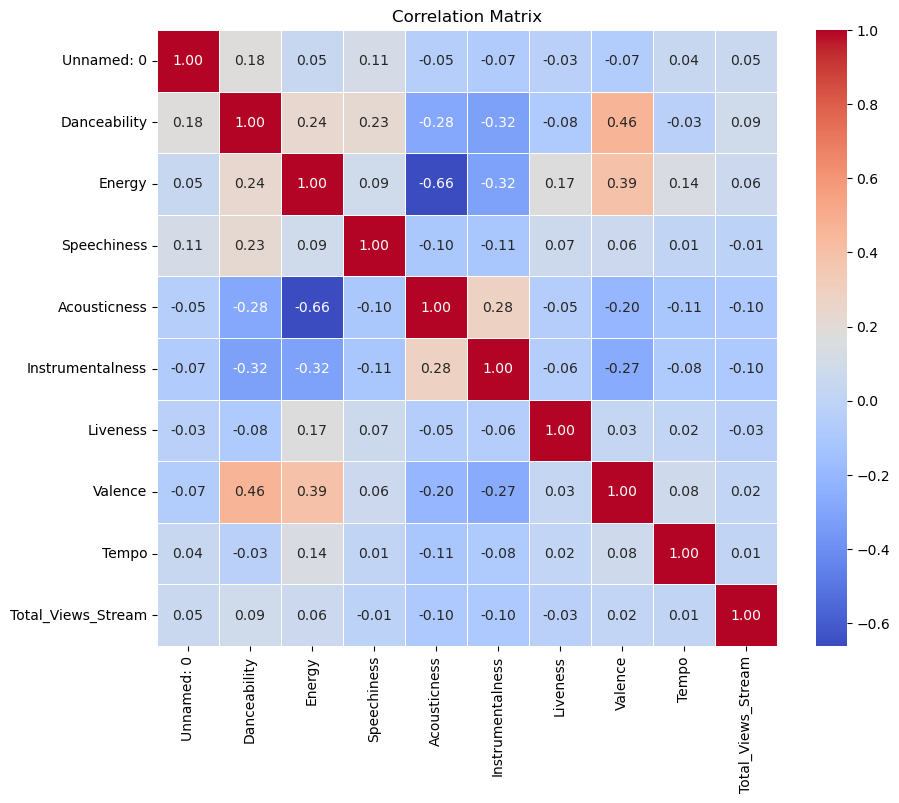

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


There seems to be a slight correlation between valence and daceability. I will try to exclude valence and rerun the model

In [12]:
# Split the data into features (X) and target (y)
X = df.drop(['Valence', 'Unnamed: 0', 'Total_Views_Stream', 'Track', 'Artist'], axis=1)
y = df['Total_Views_Stream']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse_after_feature_removal = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after feature removal: {mse_after_feature_removal}")

# Percentage of predictions within 10% of target
tolerance_percentage = 10
tolerance = tolerance_percentage / 100
within_tolerance = (abs(y_pred_after_feature_removal - y_test) / y_test) <= tolerance
count_within_tolerance = sum(within_tolerance)
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")


Mean Squared Error after feature removal: 2.267788266097875e+17
Percentage of predictions within 10% tolerance: 6.270711190415498%


Pretty similar results - will try a gridsearch CV with hyperparameterization

In [16]:
df =pd.read_csv('updated_data_filtered_V3.csv')
from sklearn.model_selection import GridSearchCV

# Drop unnecessary columns
df.drop(['Valence', 'Unnamed: 0', 'Track', 'Artist'], axis=1, inplace=True)

# Split the data into features (X) and target (y)
X = df.drop('Total_Views_Stream', axis=1)
y = df['Total_Views_Stream']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model with the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
mse_after_grid_search = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after GridSearchCV: {mse_after_grid_search}")


Mean Squared Error after GridSearchCV: 2.214230498571743e+17


In [17]:
# Percentage of predictions within 10% of target
tolerance_percentage = 10
tolerance = tolerance_percentage / 100
within_tolerance = (abs(y_pred_after_feature_removal - y_test) / y_test) <= tolerance
count_within_tolerance = sum(within_tolerance)
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Percentage of predictions within 10% tolerance: 6.270711190415498%


Still the same even with hyperparameterization

### Lets start trying unsupervised learning

In [2]:
df =pd.read_csv('updated_data_filtered_V3.csv')


#### Going to start with K-means clustering to group similar tracks based on features

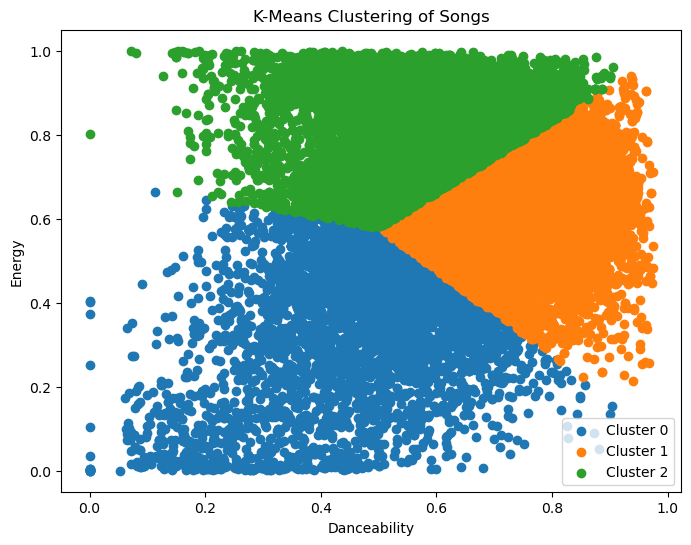

In [6]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select relevant features for clustering
features_for_clustering = df[['Danceability', 'Energy']]

# Initialize KMeans with the desired number of clusters
num_clusters = 3  # You can adjust this based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the KMeans model to the data
df['cluster'] = kmeans.fit_predict(features_for_clustering)

# Visualize the clusters in 2D space
plt.figure(figsize=(8, 6))

# Plot each cluster
for cluster_label in range(num_clusters):
    cluster_data = df[df['cluster'] == cluster_label]
    plt.scatter(cluster_data['Danceability'], cluster_data['Energy'], label=f'Cluster {cluster_label}')

plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.title('K-Means Clustering of Songs')
plt.legend()
plt.show()


In [7]:
kmeans.cluster_centers_

array([[0.46028744, 0.33186821],
       [0.74715029, 0.61383942],
       [0.57597975, 0.81494397]])

#### Trying PCA

In [10]:
numerical_columns = ['Danceability', 'Speechiness', 'Acousticness', 'Valence', 'Liveness', 'Energy', 'Instrumentalness', 'Tempo']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['Danceability', 'Speechiness', 'Acousticness', 'Valence', 'Liveness', 'Energy', 'Instrumentalness', 'Tempo']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


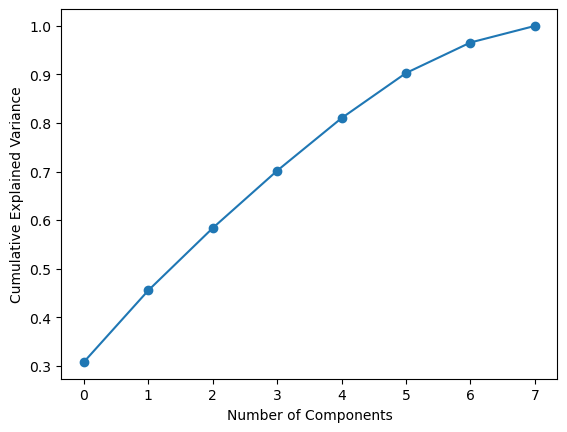

In [11]:
from sklearn.decomposition import PCA

# Assuming df is your DataFrame with standardized numerical columns
pca = PCA()
df_pca = pca.fit_transform(df[numerical_columns])

# Plot explained variance ratio
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


Elbow starts at 5 components, so this is what is enough - afterwards, there's deminishing returns.

In [19]:
from sklearn.decomposition import PCA

# Assuming df is your DataFrame and numerical_columns contains the numerical features
X = df[numerical_columns]

# Specify the number of components (you can adjust this based on your requirements)
n_components = 5
pca = PCA(n_components=n_components)

# Fit and transform the data
X_pca = pca.fit_transform(X)


Now back to supervised learning

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # You can replace this with other regression models
y = df['Total_Views_Stream']

# Assuming y is your target variable (Total_Views_Stream)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Choose a regression model (e.g., Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [25]:
from sklearn.metrics import mean_squared_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.5197205976098797e+17


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Features and target variable (excluding 'Unnamed: 0')
target_variable = 'Total_Views_Stream'  

# Extract the selected features
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model_after_feature_removal = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model_after_feature_removal.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_after_feature_removal = model_after_feature_removal.predict(X_test)

# Evaluate the model performance
mse_after_feature_removal = mean_squared_error(y_test, y_pred_after_feature_removal)
print(f"Mean Squared Error after feature removal: {mse_after_feature_removal}")

# Percentage of predictions within 10% of target
tolerance_percentage = 10
tolerance = tolerance_percentage / 100
within_tolerance = (abs(y_pred_after_feature_removal - y_test) / y_test) <= tolerance
count_within_tolerance = sum(within_tolerance)
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")


Mean Squared Error after feature removal: 2.5682734607732627e+17
Percentage of predictions within 10% tolerance: 5.021667091511598%


Still the same result. I will try to reduce dimentionality to 3

In [28]:
from sklearn.decomposition import PCA

# Assuming df is your DataFrame and numerical_columns contains the numerical features
X = df[numerical_columns]

# Specify the number of components (you can adjust this based on your requirements)
n_components = 3
pca = PCA(n_components=n_components)

# Fit and transform the data
X_pca = pca.fit_transform(X)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Features and target variable (excluding 'Unnamed: 0')
target_variable = 'Total_Views_Stream'  

# Extract the selected features
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model_after_feature_removal = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model_after_feature_removal.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_after_feature_removal = model_after_feature_removal.predict(X_test)

# Evaluate the model performance
mse_after_feature_removal = mean_squared_error(y_test, y_pred_after_feature_removal)
print(f"Mean Squared Error after feature removal: {mse_after_feature_removal}")

# Percentage of predictions within 10% of target
tolerance_percentage = 10
tolerance = tolerance_percentage / 100
within_tolerance = (abs(y_pred_after_feature_removal - y_test) / y_test) <= tolerance
count_within_tolerance = sum(within_tolerance)
percentage_within_tolerance = (count_within_tolerance / len(y_test)) * 100
print(f"Percentage of predictions within {tolerance_percentage}% tolerance: {percentage_within_tolerance}%")

Mean Squared Error after feature removal: 2.7116994054201152e+17
Percentage of predictions within 10% tolerance: 4.766760132551619%


This increased the error and reduced prediction meaning we lost valuable data 

#### Conclusion

After running all these models, tuning the data, and changing parameters, the model was not successful in reaching the target. This could be due to not having enough data points or the features not being as exclusive or valuable. The next, long term steps for this project would be to try and extract more meaningful data from the music and go from there.